In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import seaborn as sb
from sklearn.decomposition import PCA
from matplotlib.ticker import AutoMinorLocator
from sklearn.preprocessing import StandardScaler
import warnings
import pickle
import pandas_datareader as pdr
import pandas_datareader.data as web

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

warnings.filterwarnings("ignore", category=FutureWarning, module="yfinance")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas_datareader.data")

# Stocks

## Fama-French

In [15]:
column_trans = {'Clths': 'Apparel', 'Banks': 'Banks', 'RlEst': 'Real Estate', 'Food ': 'Food', 'Oil  ': 'Energy', 'Hlth ': 'Health',
                'Meals': 'Restaurants, Hotels, Resorts', 'Hshld': 'Household', 'Fun  ': 'Leisure', 'PerSv': 'Personal Services', 'BusSv': 'Business Services',
               'Trans': 'Transportation', 'Telcm': 'Communication', 'Softw': 'Computer Software', 'Beer ': 'Beer, Ale, Malt',
               'Toys ': 'Toys', 'Soda ': 'Candy & Soda', 'Aero ': 'Aircraft', 'Gold ': 'Precious Metals'}

In [16]:
market = yf.download(['^GSPC','^IXIC'], interval='1mo')['Adj Close'].pct_change().mean(axis=1)
market.index = market.index.to_period('M')
market.name = 'S&P500 - Nasdaq'

[*********************100%***********************]  2 of 2 completed


In [19]:
dt = web.DataReader('49_Industry_Portfolios','famafrench', start='2000-01-01') #Daily
dt = dt[0] #1 Average Equal Weighted Returns  2 Average Value Weighted Returns
stock_dict = dt[column_trans.keys()].rename(columns = column_trans) / 100
stock_dict = stock_dict.join(market)
stock_dict.tail()

,Apparel,Banks,Real Estate,Food,Energy,Health,"Restaurants, Hotels, Resorts",Household,Leisure,Personal Services,Business Services,Transportation,Communication,Computer Software,"Beer, Ale, Malt",Toys,Candy & Soda,Aircraft,Precious Metals,S&P500 - Nasdaq
Date,,,,,,,,,,,,,,,,,,,,
2023-12,0.0462,0.0968,0.1745,0.0433,0.0003,0.0985,0.0506,0.0032,0.0398,0.0924,0.0735,0.0730,0.0226,0.0313,0.0055,0.1015,0.0226,0.0664,0.0234,0.049709
2024-01,-0.0516,0.0156,-0.0508,-0.0154,-0.0020,-0.0006,0.0062,0.0377,0.0789,-0.0330,0.0006,-0.0156,0.0453,0.0385,-0.0082,-0.0563,-0.0072,-0.0237,-0.1677,0.013033
2024-02,0.0598,0.0404,0.0467,-0.0092,0.0299,0.0284,0.0546,0.0300,0.0644,0.0356,0.0350,0.0849,-0.0272,0.0456,0.0010,0.0370,0.0432,0.0198,-0.0880,0.056456
2024-03,-0.0627,0.0538,0.0283,0.0390,0.1047,0.0587,0.0088,0.0311,0.0106,0.0497,0.0344,0.0060,0.0308,0.0179,0.0461,0.0214,0.0199,0.0321,0.1878,0.024444
2024-04,-0.0639,-0.0390,-0.1139,0.0065,-0.0063,-0.0774,-0.0232,-0.0158,-0.0964,-0.0534,-0.0600,-0.0838,-0.0652,-0.0504,-0.0197,-0.0320,-0.0187,-0.0153,0.1234,-0.042836


In [20]:
cpi_dict_ff = {'Candy & Soda': 'Food at home', 'Toys': 'Toys', 'Beer, Ale, Malt': 'Beer, ale, and other malt beverages at home',
              'Apparel': 'Apparel', 'Banks': 'All items', 'Food': 'Food and beverages', 'Computer Software': 'Information technology, hardware and services',
              'Real Estate': 'Rent of primary residence', 'Energy': 'Energy commodities', 'Leisure': 'Recreation services',
              'Personal Services': 'Services', 'Business Services': 'Professional services', 
               'Aircraft': 'Airline fares', 'Transportation': 'Transportation', 'Restaurants, Hotels, Resorts': 'Lodging away from home',
              'Health': 'Medical care', 'Precious Metals': 'All items', 'Household': 'Household furnishings and supplies',
              'Communication': 'Communication', 'S&P500 - Nasdaq': 'All items'}

## Manual download

In [23]:
sp500 = pd.read_excel('csv/S P 500 SPX Constituents.xls', header=14)[['Company Name','Exchange:Ticker','Primary Industry']].iloc[:503]
sp500['Ticker'] = sp500['Exchange:Ticker'].str.split(':').str[1]
sp500['Ticker'] = sp500['Exchange:Ticker'].str.split(':',expand=True)[1]

nasdaq = pd.read_excel('csv/NASDAQ Composite Index COMP Constituents.xls', header=9)[['Company Name','Exchange:Ticker','CIQ Primary Industry']].rename(columns={'CIQ Primary Industry': 'Primary Industry'}).iloc[:3360]
nasdaq['Ticker'] = nasdaq['Exchange:Ticker'].str.split(':').str[1]

cpi_dict = {'S&P500 - Nasdaq': 'All items less food and energy', 'Education': 'Education', 'Food':'Food and beverages',
        'Restaurants': 'Meats', 'Household': 'Household furnishings and supplies', 'Apparel': 'Apparel less footwear',
        'Bank': 'All items', 'Gas': 'Gasoline (all types)', 'Transportation': 'Transportation', 'Leisure': 'Recreation services',
        'Services': 'Services', 'Health': 'Medical care', 'Hotels, Resorts': 'Lodging away from home', 
        'Passenger Airlines': 'Airline fares', 'Luxury': 'Jewelry', 'Telecommunication': 'Communication',
        'Technology ': 'Information technology, hardware and services', 'Estate': 'Rent of primary residence'}

In [ ]:
stock_dict = {}
with open('csv/stock_dict_combined16.pkl', 'rb') as f:
    stock_dict = pickle.load(f)

###### Research stock

In [24]:
# Find stocks with industry
mix_ = pd.concat([sp500,nasdaq], axis=0)
mix_[(mix_['Primary Industry'].str.contains('Sauce'))]

,Company Name,Exchange:Ticker,Primary Industry,Ticker


# Macroeconomic variables

In [26]:
def get_fred_prices(assets, print_=True):
    df_temp = pd.DataFrame()
    beginning_date = '2000-01-01'
    for key, value in assets.items():
        print('Getting {} with symbol {}'.format(key, value)) if print_ == True else 0
        try:
            df_temp[f'{key}'] = pdr.DataReader(f'{value}','fred', beginning_date)
        except:
            print('Error getting {}'.format(value))
    return(df_temp)

## CPI
### Data pre-processing

In [27]:
raw_2010_2014 = pd.read_excel('csv/revised-seasonally-adjusted-indexes-2014.xlsx', header=0)

raw_2014_2018 = pd.read_excel('csv/revised-seasonally-adjusted-indexes-2018.xlsx', header=0)

raw_2019_2023 = pd.read_excel('csv/revised-seasonally-adjusted-indexes-2023.xlsx', header=0)

raw_data = pd.concat((raw_2010_2014, raw_2014_2018, raw_2019_2023), axis=0)
#raw_data = raw_2019_2023
raw_data = raw_data[(raw_data['DATA_TYPE']=='SEASONALLY ADJUSTED INDEX')]
print(raw_data.shape)
raw_data.sample(5)

/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


(6820, 18)


/Users/grtk/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


,TITLE,ITEM,SERIESID,DATA_TYPE,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,seriesid
3227,Other intercity transportation,SETG02,CUSR0000SETG02,SEASONALLY ADJUSTED INDEX,2016,155.962,156.203,156.166,155.935,160.179,158.681,157.934,159.853,159.442,158.879,160.923,159.690,NaN
5494,Dairy and related products,SEFJ,CWSR0000SEFJ,SEASONALLY ADJUSTED INDEX,2018,214.461,214.175,214.543,215.188,214.969,216.380,215.154,215.403,215.041,214.487,214.101,214.382,NaN
1099,Alcoholic beverages,SAF116,CWSR0000SAF116,SEASONALLY ADJUSTED INDEX,2014,238.655,238.260,238.645,238.893,239.095,239.143,238.867,240.258,240.553,240.819,242.275,241.564,NaN
3094,New vehicles,SETA01,CUSR0000SETA01,SEASONALLY ADJUSTED INDEX,2018,146.664,145.965,145.984,145.416,145.950,146.499,146.575,146.623,146.606,146.361,146.407,146.416,NaN
6379,Nonelectric cookware and tableware,SEHL04,CWSR0000SEHL04,SEASONALLY ADJUSTED INDEX,2018,81.447,82.573,83.426,83.254,83.891,82.743,82.109,81.585,81.504,82.317,81.658,82.452,NaN


In [28]:
data = raw_data[['TITLE','YEAR','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]
data = data.pivot_table(index=['YEAR','TITLE'], sort=False).unstack().swaplevel(axis='columns') #same index='YEAR', columns='TITLE'
data = data.sort_index(axis=1, level=0, sort_remaining=False)
data.iloc[:,:].dropna(axis=1).head()

TITLE Airline fares                                                      \
                JAN       FEB       MAR       APR        MAY        JUN   
YEAR                                                                      
2010      271.87450  269.4520  269.5230  271.4830  273.70900  275.44750   
2011      298.15950  302.4130  306.3840  302.6595  296.71950  293.83600   
2012      304.06800  302.9210  304.1320  304.4230  303.33750  299.22100   
2013      316.91300  314.4850  316.3360  309.5910  309.94200  308.93250   
2014      301.92825  302.1875  303.9955  307.0535  318.93925  320.76125   

TITLE                                            ...  \
            JUL       AUG        SEP        OCT  ...   
YEAR                                             ...   
2010   277.0130  276.8210  276.58400  277.99200  ...   
2011   299.9885  305.8945  307.03550  304.87800  ...   
2012   299.4515  299.7070  302.20550  303.09400  ...   
2013   308.9580  306.2395  307.05100  309.76050  ...   
2014   307.8185  302.4660  300.89975  302.54025  ...   

TITLE Women's suits and separates                                        \
                              MAR      APR      MAY       JUN       JUL   
YEAR                                                                      
2010                     85.11600  85.4710  86.1300  84.80550  84.48850   
2011                     83.04350  83.7695  84.0600  84.45550  84.92200   
2012                     84.37050  87.3570  89.2785  88.08500  87.99750   
2013                     88.52250  87.3815  86.7820  85.27300  87.23200   
2014                     86.78475  86.3355  86.1580  86.15025  85.51575   

TITLE                                               
           AUG      SEP      OCT      NOV      DEC  
YEAR                                                
2010   84.0175  83.1915  82.5990  83.2835  83.5020  
2011   85.0825  84.8455  85.4895  86.1125  85.3895  
2012   87.3530  87.6490  88.1925  88.0795  87.5525  
2013   88.7510  87.4225  86.0785  85.9930  89.8675  
2014   86.0285  85.4695  84.6785  83.6980  83.0085  

[5 rows x 2340 columns]

In [29]:
#data.to_excel('clean_data.xlsx')

### Data cleaning — ordering

In [30]:
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6, 
             'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}

In [31]:
cpi_industry = raw_data[['TITLE','YEAR','JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']]
cpi_industry = cpi_industry.melt(id_vars=['TITLE','YEAR'], var_name='MONTH', value_name='CPI')
cpi_industry['Date'] = pd.to_datetime(cpi_industry['YEAR'].astype(str) + '-' + cpi_industry['MONTH'].map(month_map).astype(str))
cpi_industry = cpi_industry.pivot_table(index='Date', columns='TITLE', values='CPI')
cpi_industry.index = cpi_industry.index.to_period('M')
cpi_industry.dropna(axis=1, inplace=True)
cpi_industry.head()

TITLE,Airline fares,Alcoholic beverages,Alcoholic beverages at home,All items,All items less energy,All items less food,All items less food and energy,All items less food and shelter,"All items less food, shelter, and energy","All items less food, shelter, energy, and used cars and trucks",...,Video and audio products,Video and audio services,Water and sewer and trash collection services,Water and sewerage maintenance,Women's and girls' apparel,Women's apparel,Women's dresses,Women's footwear,Women's outerwear,Women's suits and separates
Date,,,,,,,,,,,,,,,,,,,,,
2010-01,271.8745,222.8030,192.4160,215.4205,217.0060,214.8920,217.3450,204.991,205.658,209.427,...,98.8750,101.1945,166.9810,367.1950,107.8750,110.0640,111.0220,126.4580,94.5860,85.5515
2010-02,269.4520,222.5710,192.2150,215.2030,217.1235,214.6205,217.4655,204.635,205.836,209.593,...,97.1950,100.4565,168.0585,369.5750,108.4125,109.6825,112.4285,126.9860,93.9280,85.3985
2010-03,269.5230,222.6385,191.8155,215.2930,217.2660,214.6570,217.5580,204.696,205.967,209.789,...,97.0245,100.6015,168.8110,371.4900,108.2575,110.2065,111.8325,126.2595,96.0625,85.1160
2010-04,271.4830,222.7435,191.9235,215.3535,217.3380,214.6850,217.5965,204.708,206.002,209.875,...,96.7410,100.6055,169.6300,373.7815,107.0715,109.3075,109.0010,125.9530,95.4125,85.4710
2010-05,273.7090,222.9340,192.4590,215.2190,217.4860,214.5065,217.7480,204.401,206.126,210.059,...,95.4585,100.4780,170.3620,375.9195,107.0145,109.4210,106.8640,125.7275,94.4080,86.1300


In [32]:
extreme_corr = cpi_industry.pct_change().corr().melt(ignore_index=False).sort_values(by='value',ascending=False).iloc[::2]
display(extreme_corr.sort_values(by='value',ascending=False).iloc[106:114])
display(extreme_corr.sort_values(by='value',ascending=True).iloc[:10])

,TITLE,value
TITLE,,
Energy commodities,Gasoline (all types),0.999497
Energy commodities,"Gasoline, unleaded regular",0.999113
Food,Food and beverages,0.998934
Communication,Information and information processing,0.998899
All items less medical care,All items,0.998122
Lodging away from home,Other lodging away from home including hotels ...,0.998043
Household energy,Fuels and utilities,0.998033
Transportation,Private transportation,0.997737


,TITLE,value
TITLE,,
Motor vehicle insurance,"Meats, poultry, and fish",-0.499933
Motor vehicle insurance,"Meats, poultry, fish, and eggs",-0.481672
Motor vehicle insurance,Meats,-0.453805
Motor vehicle insurance,Other recreation services,-0.406439
Transportation services,"Meats, poultry, and fish",-0.375906
"Meats, poultry, fish, and eggs",Transportation services,-0.366309
Meats,Transportation services,-0.351197
Motor vehicle insurance,Food at home,-0.313893
Motor vehicle insurance,Recreation services,-0.311025


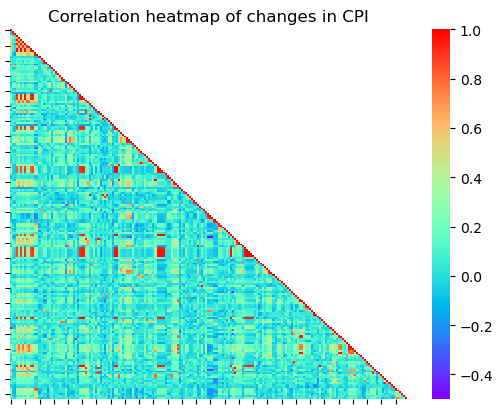

In [33]:
cpi_corr_df = pd.DataFrame(np.tril(cpi_industry.pct_change().corr(), 0)).replace(0,np.nan)
hm = sb.heatmap(cpi_corr_df,cmap='rainbow')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.xlabel('')
plt.ylabel('')
plt.title('Correlation heatmap of changes in CPI');

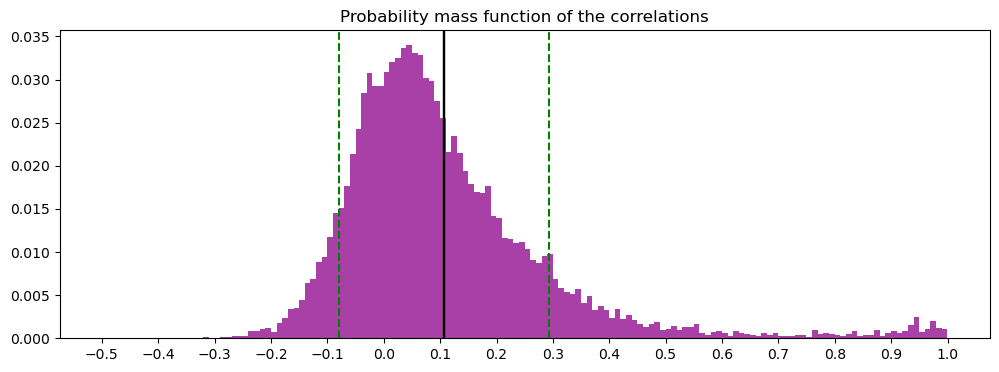

In [34]:
values = extreme_corr.iloc[106:].value
plt.figure(figsize=(12,4))
weights = np.ones_like(values)/len(values)
values.hist(bins=150, weights=weights, cumulative=False, alpha=0.75, color='darkmagenta')
plt.axvline(values.mean(), color='black', ls='-', lw=1.75)
plt.axvline(values.mean() + values.std(), color='green', ls='--')
plt.axvline(values.mean() - values.std(), color='green', ls='--')
plt.grid(False)
plt.xticks(np.arange(-0.5,1.1,0.1))
plt.title('Probability mass function of the correlations');

In [35]:
print(f'{np.tril(cpi_corr_df,-1).mean():.2%}') #mean distrib
count_ = cpi_industry.pct_change().corr()
unique_pair = ((count_>=-.2) & (count_<=.0)).sum().sum() / 2
print(unique_pair)
print('{:.2%}'.format(unique_pair/(195*195/2)))

5.36%
5114.0
26.90%


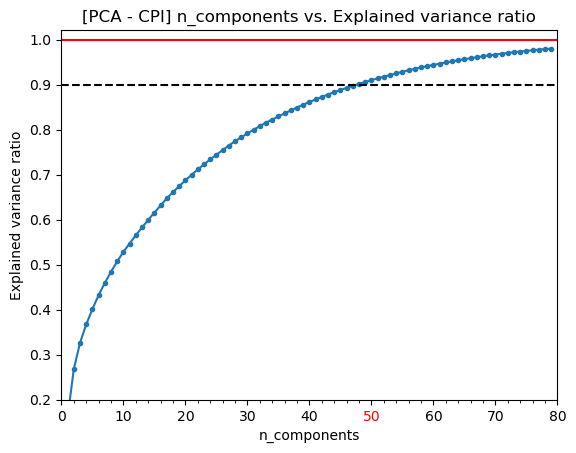

In [36]:
sum_var = []
for x in range(1,80):
    X = StandardScaler().fit_transform(cpi_industry.pct_change().dropna().values)
    pca = PCA(n_components=x)
    pca.fit(X)
    sum_var.append(pca.explained_variance_ratio_.sum())

x = range(1,len(sum_var)+1)
plt.plot(x, sum_var, marker='o', markersize=3)
plt.axhline(y=0.9, ls='--', color='black')
plt.axhline(y=1, color='r')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('[PCA - CPI] n_components vs. Explained variance ratio')
plt.ylim(round(min(sum_var),1),)
plt.xlim(0,len(sum_var)+1)
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
for a in plt.gca().get_xticklabels():
    if int(a.get_position()[0]) == np.round((np.array(sum_var)>.9).argmax(),-1):
        a.set_color('red')
plt.show()
#print(pca.singular_values_)

In [37]:
func = np.poly1d(np.polyfit(np.log(x), np.array(sum_var), 1))
func
#plt.plot(x, func(np.log(x)))

poly1d([0.21055521, 0.07319661])

In [38]:
pd.DataFrame(pca.components_[0], index=cpi_industry.columns).rename(columns={0:'PC1'}).sort_values('PC1', ascending=False).iloc[:10]

,PC1
TITLE,
All items,0.165552
All items less medical care,0.165276
All items less food,0.158865
All items less shelter,0.158340
All items less food and shelter,0.152603
All items less energy,0.145538
Commodities,0.144720
"All items less food, shelter, energy, and used cars and trucks",0.143550
"Commodities less food, energy, and used cars and trucks",0.139476


### CPI per category

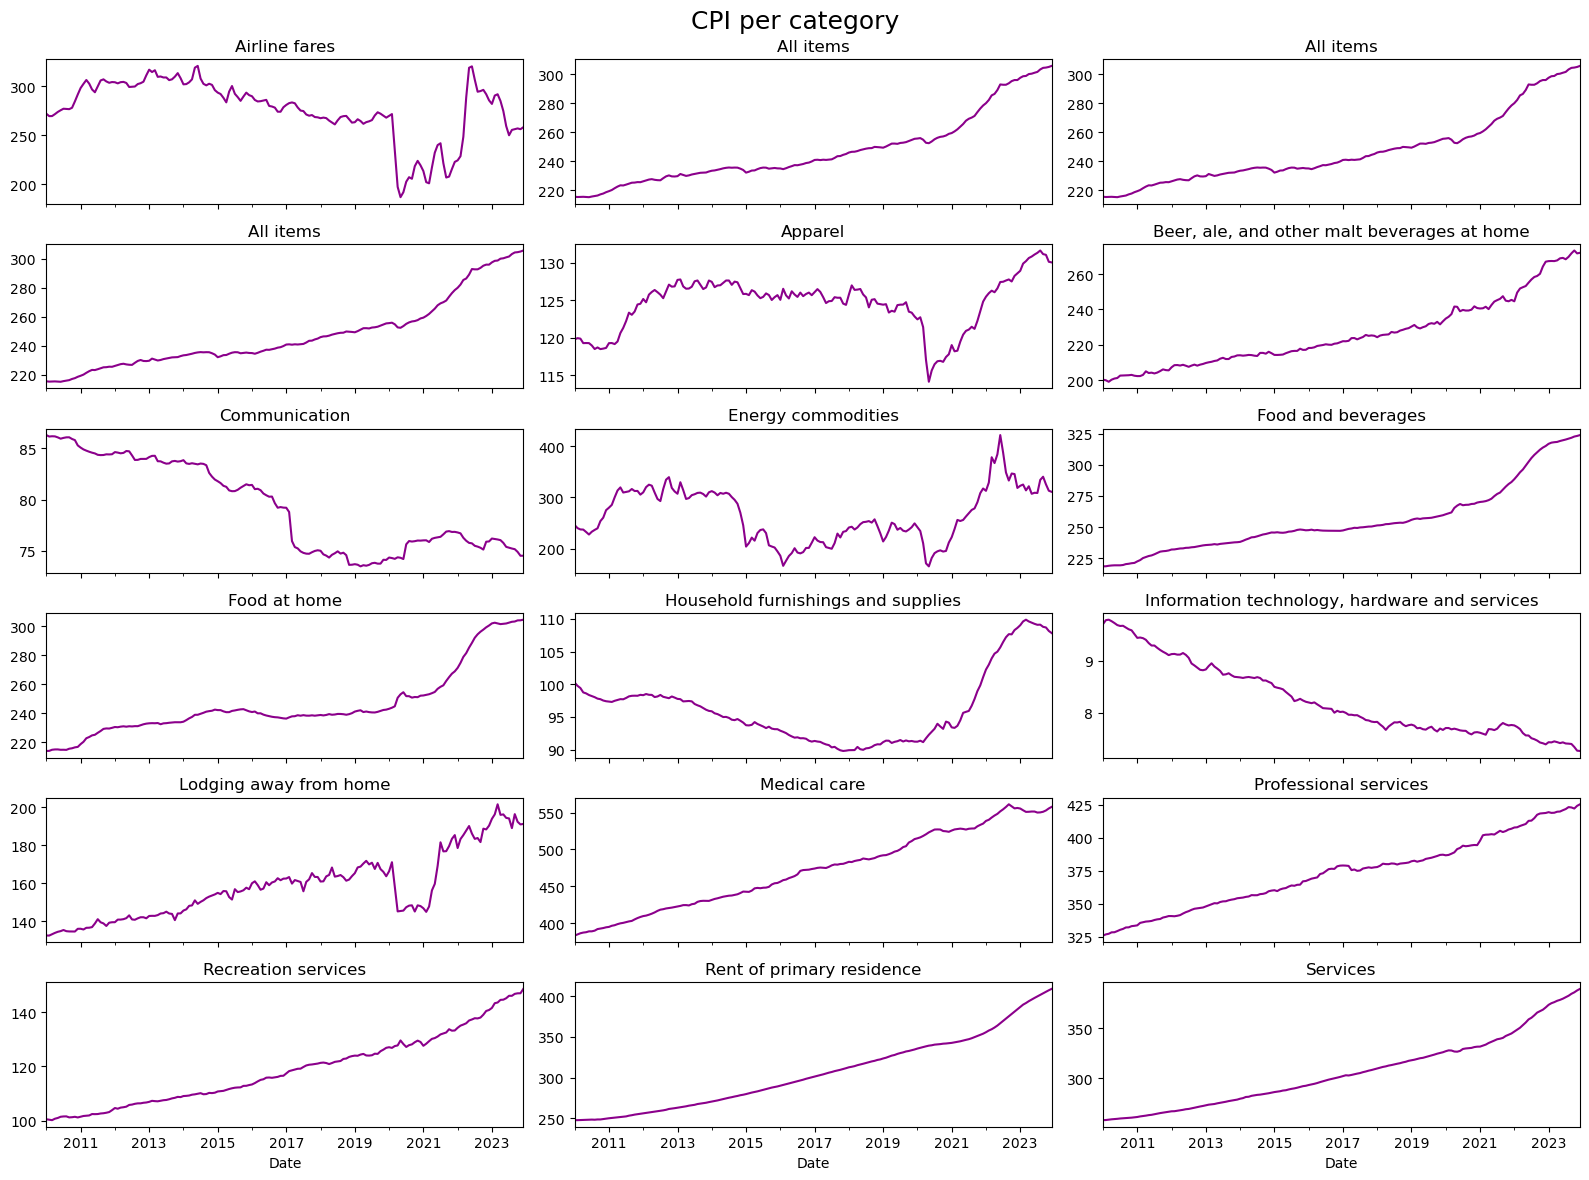

In [42]:
fig, axes = plt.subplots(int(len(cpi_dict_ff)/3), 3, figsize=(16,12), sharex=True)

for loc, title in zip(axes.ravel(), sorted(list(cpi_dict_ff.values()))):
    cpi_industry[title].plot(ax=loc, color='darkmagenta')
    loc.set_title(title)

#b = fig.add_subplot(531)
#b.plot(np.arange(5), [5]*5)
plt.suptitle('CPI per category', fontsize=18)
plt.tight_layout()

### Correlation per dict

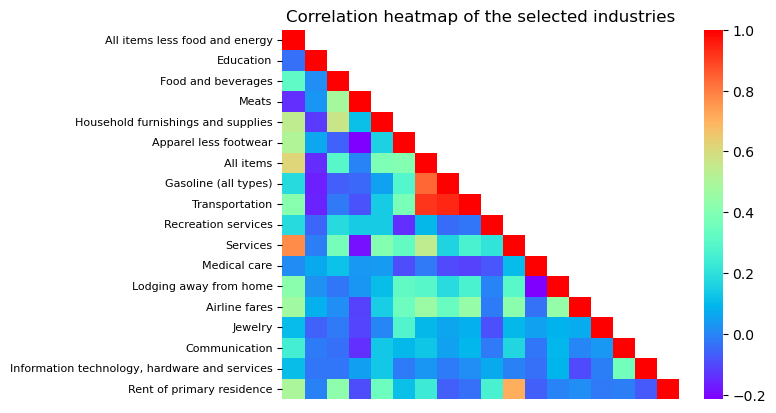

In [43]:
corr_cpi_dict = cpi_industry[cpi_dict.values()].pct_change().corr()
sb.heatmap(pd.DataFrame(np.tril(corr_cpi_dict, 0), columns=corr_cpi_dict.columns, index=corr_cpi_dict.index).replace(0,np.nan), cmap='rainbow')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=8)
plt.gca().set_xticks([])
plt.title('Correlation heatmap of the selected industries');

## Unemployment rate

In [44]:
UNRATE = pd.read_excel('csv/UNRATE.xls', header=0, index_col=0)
UNRATE.index = UNRATE.index.to_period('M')
UNRATE.tail()

,UNRATE
observation_date,
2023-12,3.7
2024-01,3.7
2024-02,3.9
2024-03,3.8
2024-04,3.9


## GDP

In [45]:
GDP = get_fred_prices({'Real_GDP':'GDPC1'})
GDP.index = GDP.index.to_period('M')
GDP

Getting Real_GDP with symbol GDPC1


,Real_GDP
DATE,
2000-01,13878.147
2000-04,14130.908
2000-07,14145.312
2000-10,14229.765
2001-01,14183.120
...,...
2023-01,22112.329
2023-04,22225.350
2023-07,22490.692


## Average hourly earnings

In [46]:
avg_h_e = get_fred_prices({'Avg_hourly_earnings':'CES0500000003'})#.pct_change().dropna()
avg_h_e.columns = ['Avg_h_earnings']
avg_h_e.index = avg_h_e.index.to_period('M')
avg_h_e

Getting Avg_hourly_earnings with symbol CES0500000003


,Avg_h_earnings
DATE,
2006-03,20.05
2006-04,20.15
2006-05,20.13
2006-06,20.23
2006-07,20.29
...,...
2023-12,34.34
2024-01,34.51
2024-02,34.56


## 13-week T-BILL

In [47]:
rate = yf.download('^IRX', interval='1mo')['Close'][:-3]
rate.index = rate.index.to_period('M')
rate.tail()

[*********************100%***********************]  1 of 1 completed


Date
2023-10    5.320
2023-11    5.238
2023-12    5.180
2024-01    5.188
2024-02    5.223
Freq: M, Name: Close, dtype: float64

## US Dollar Index

In [48]:
USD = pd.read_csv('csv/FXCM.csv', header=0, index_col=0, thousands='.', decimal=',').rename(columns={'Dernier':'FXCM'})['FXCM']#.astype('float16')
USD.index = pd.to_datetime(USD.index, dayfirst=True).to_period('M')
USD = USD.astype('int').sort_index()
USD.tail()

Date
2022-11    12990
2022-12    12843
2023-01    12707
2023-02    12808
2023-03    12808
Freq: M, Name: FXCM, dtype: int64

## Money supply

In [49]:
M2 = get_fred_prices({'Money Supply': 'M2SL'}, print_=False)
M2.index = M2.index.to_period('M')
M2.tail()

,Money Supply
DATE,
2023-12,20754.0
2024-01,20754.2
2024-02,20748.6
2024-03,20841.5
2024-04,20867.3


## PPI

## ——————————Descriptive statistics——————————

In [51]:
summary_stats = pd.DataFrame()
if type(stock_dict) == dict:
    for key in stock_dict.keys():
        stock, deleted = delete_outlier(stock_dict[key].pct_change(fill_method=None).loc[str(cpi_industry.index.min()):str(cpi_industry.index.max()),:],
                               threshold = .35, key = key, method = 'value', print_ = False)
        summary_stats[key] = stock.describe()
else:
    for key in stock_dict.columns:
        summary_stats[key] = stock_dict[key].loc[str(cpi_industry.index.min()):str(cpi_industry.index.max())].describe()
summary_stats.sort_index(axis=1).iloc[:3].T.round({'count':0,'mean':3,'std':3}).rename(columns={'count':'N','mean':'Mean','std':'Std.Dev.'})

,N,Mean,Std.Dev.
Aircraft,168.0,0.013,0.066
Apparel,168.0,0.012,0.064
Banks,168.0,0.010,0.062
"Beer, Ale, Malt",168.0,0.010,0.038
Business Services,168.0,0.012,0.054
Candy & Soda,168.0,0.011,0.043
Communication,168.0,0.008,0.046
Computer Software,168.0,0.014,0.051
Energy,168.0,0.008,0.080
Food,168.0,0.008,0.037


# Regressions
### Single regression

In [52]:
def n_middle_values(row, exclude_pct):
    row = row.dropna()
    value_count = row.count()
    if value_count > 10:
        exclude = int( int(exclude_pct * value_count) / 2 )
        top_to_exclude = row.nlargest(exclude).sum()
        bottom_to_exclude = row.nsmallest(exclude).sum()
        sum_to_exclude = top_to_exclude + bottom_to_exclude
        return (row.sum() - sum_to_exclude) / (value_count - exclude * 2)
    else:
        return row.mean()

def delete_outlier(df, threshold, key, method, axis=0, print_=True):
    if type(df) == pd.core.frame.DataFrame:
        if method == 'value':
            original_, deleted_ = df.count().sum(), df[abs(df)>threshold].count().sum()
            deleted = df[abs(df)>threshold].count().sum()
            [print(f'{key}: outliers deleted {deleted}/{original_} ({deleted_/original_:.2%})') if print_==True else 0]
            df[abs(df)>threshold] = np.nan
#            return df, [deleted_, original_]
        elif method == 'index':
            max_values = df.max(axis=axis)
            if axis==0: #delete ticker
                to_drop = max_values[max_values > threshold].index
                print(f'{key}: outliers deleted {len(to_drop)}/{len(max_values)}')
                return df.drop(to_drop, axis=1)
            elif axis==1: #delete index
                to_drop = max_values[max_values > threshold].index
                print(f'{key}: outliers deleted {len(to_drop)}/{len(max_values)}')
                return df.drop(to_drop, axis=0)
            
    df = df.resample('SMS').sum().rolling(2, min_periods=1).sum()
    df = df.apply(n_middle_values, args=[.02], axis=1)
    df = df.iloc[df.index.day==1]
    df.index = df.index.to_period('M')
    return df, [deleted_, original_]

In [53]:
def update_df(df, model):
    df.at[key, 'Beta_0'] = model.params.iloc[0]
    df.at[key, 'Beta_1'] = model.params.iloc[1]
    df.at[key,'T_stat_alpha'] = model.tvalues.iloc[0]
    df.at[key,'T_stat_beta'] = model.tvalues.iloc[1]
    df.at[key,'p_value_beta'] = model.pvalues.iloc[1]
    df.at[key,'R_squared_adj'] = model.rsquared_adj
    df.at[key,'No_Obs'] = model.nobs
    
def industry_recap(df, deleted):
    df.at[key, 'Number of stocks'] = len(stock_dict[key].columns)
    df.at[key, 'Corresponding CPI\'s category'] = cpi_dict[key]
    df.at[key, 'Deleted values (outliers)'] = f'{str(deleted[0])}/{str(deleted[1])} ({(deleted[0]/deleted[1]):.2%})'
    
def highlight_p(value):
    if value < 0.05:
        color ='green'
    elif value > 0.05 and value < 0.1:
        color ='orange'
    else:
        color ='black'
#    bg = 'forestgreen' if value < 0.05 else None
    return f'color: {color}'#'; background-color: {bg}'    

#### Manual Regression

Apparel: outliers deleted 102/90560 (0.11%)
Bank: outliers deleted 503/1056776 (0.05%)
Education: outliers deleted 110/43651 (0.25%)
Estate: outliers deleted 60/58829 (0.10%)
Food: outliers deleted 181/142416 (0.13%)
Gas: outliers deleted 362/218869 (0.17%)
Health: outliers deleted 1301/610460 (0.21%)
Hotels, Resorts: outliers deleted 26/50191 (0.05%)
Household: outliers deleted 24/39390 (0.06%)
Leisure: outliers deleted 49/46130 (0.11%)
Luxury: outliers deleted 68/46436 (0.15%)
Passenger Airlines: outliers deleted 10/32530 (0.03%)
Restaurants: outliers deleted 29/100168 (0.03%)
S&P500 - Nasdaq: outliers deleted 0/7044 (0.00%)
Services: outliers deleted 2127/998225 (0.21%)
Technology : outliers deleted 64/98459 (0.07%)
Telecommunication: outliers deleted 55/40275 (0.14%)
Transportation: outliers deleted 354/189455 (0.19%)


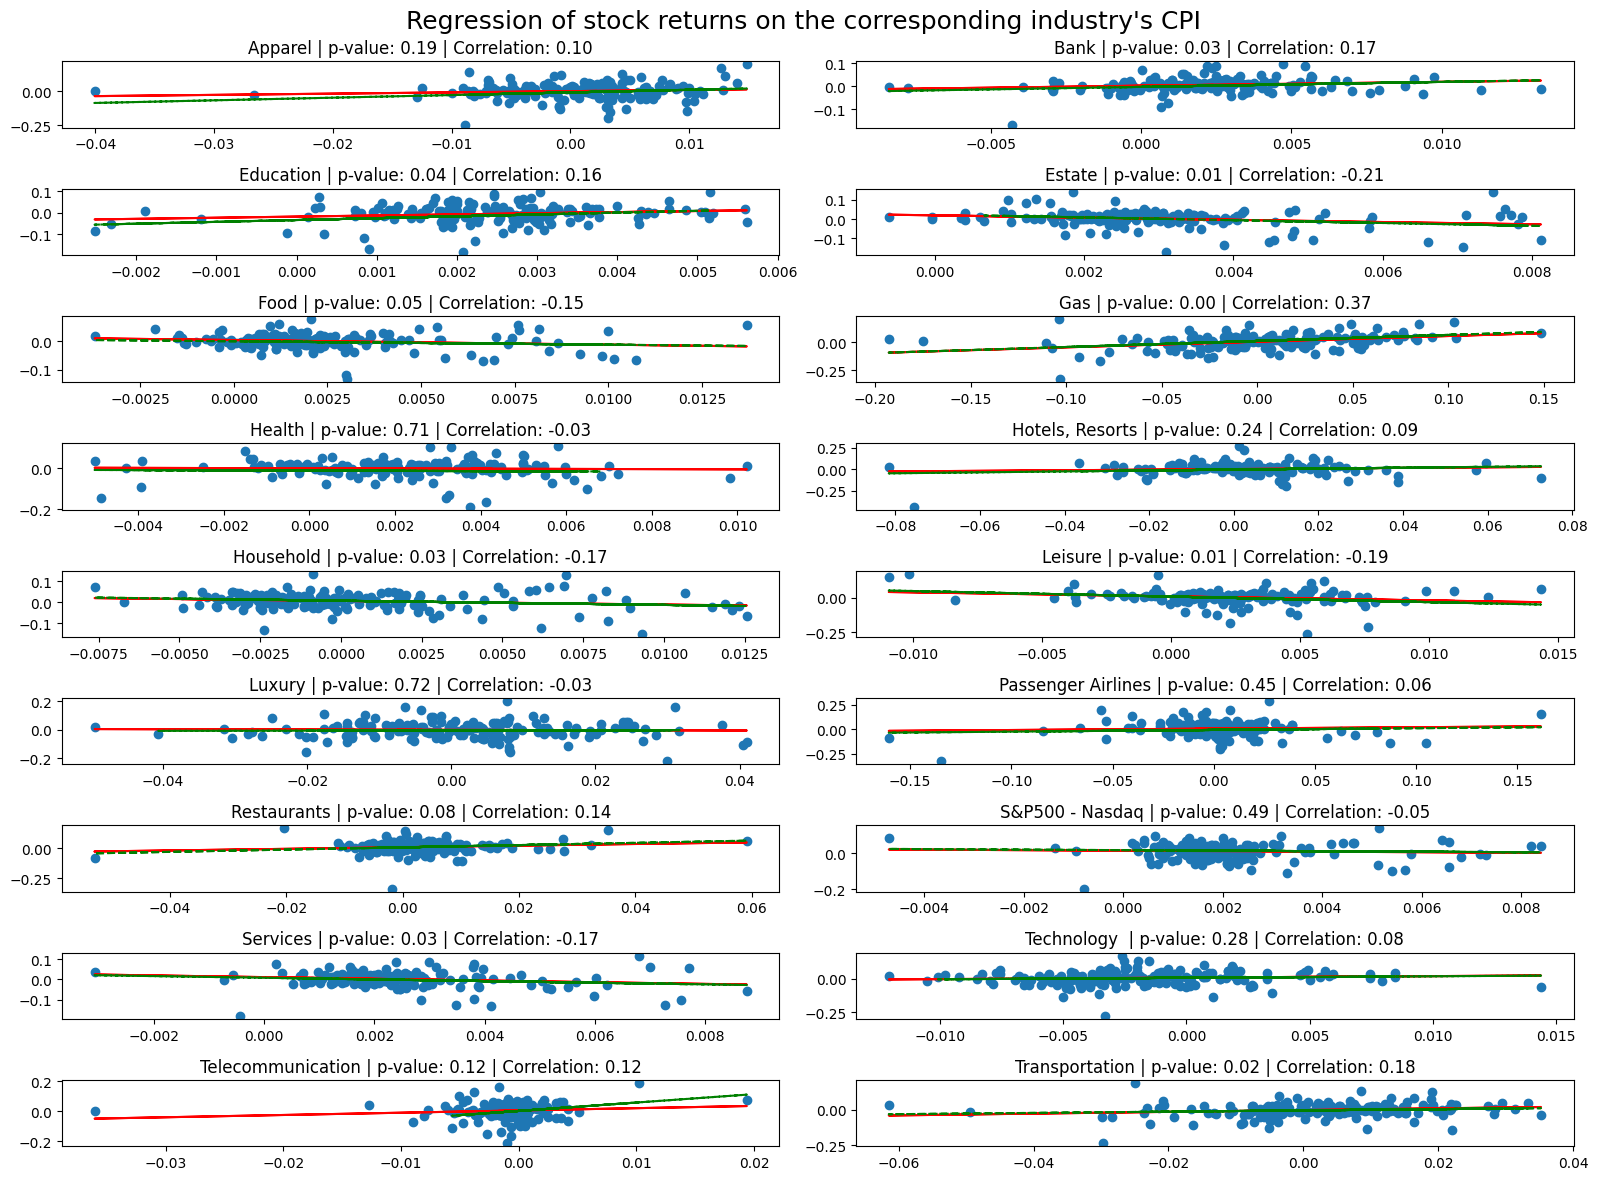

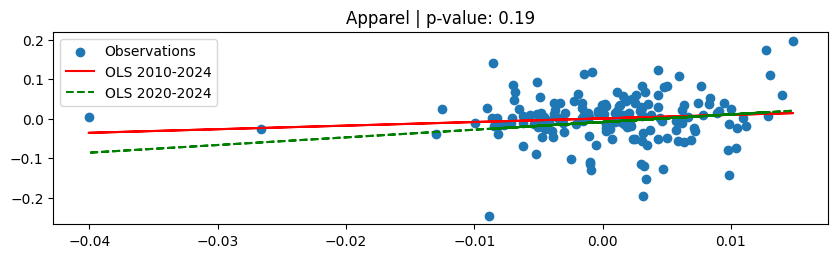

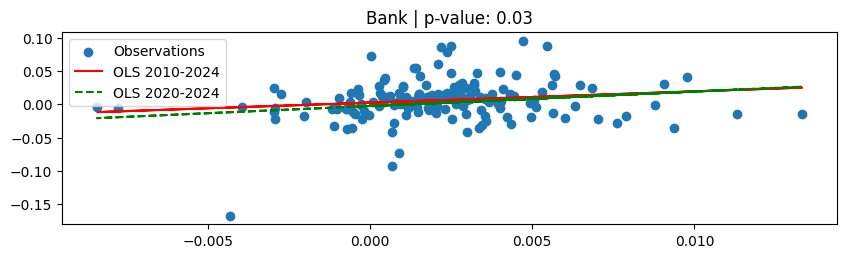

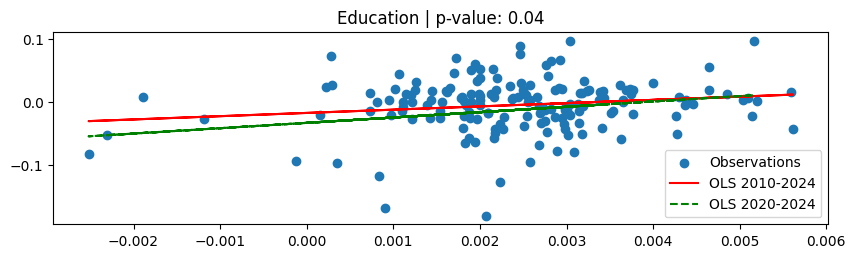

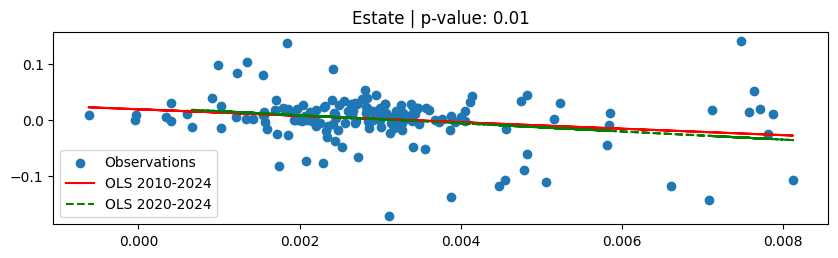

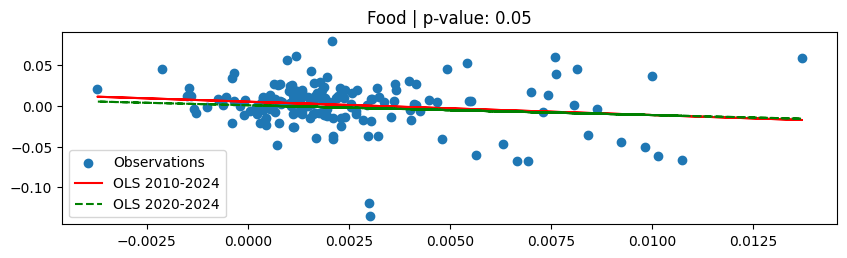

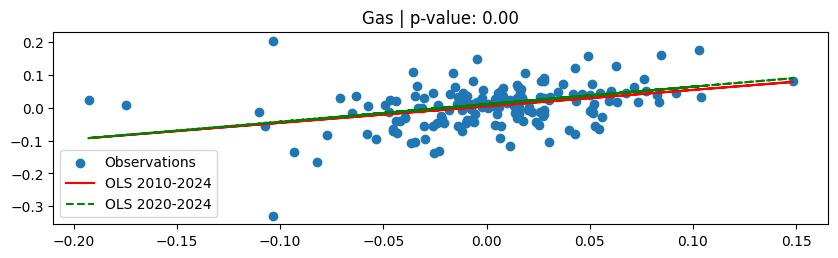

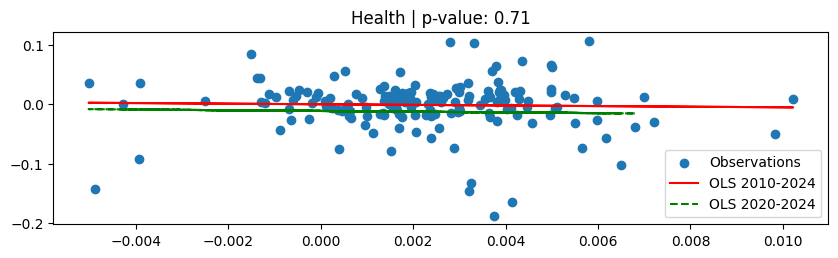

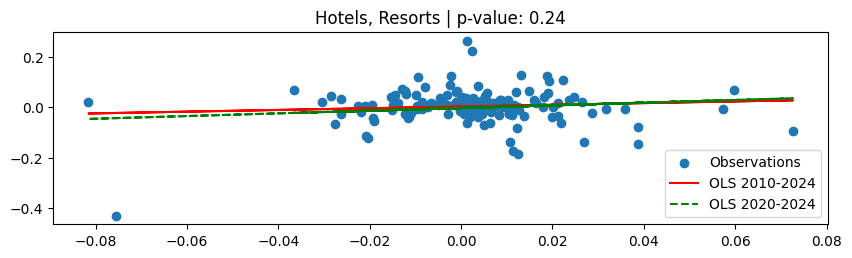

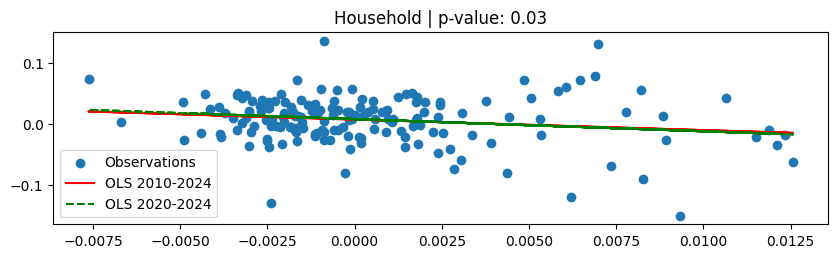

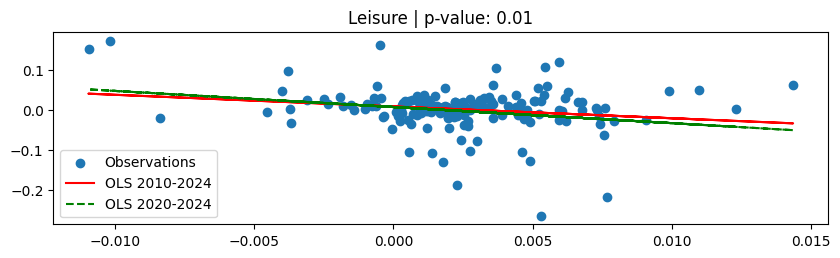

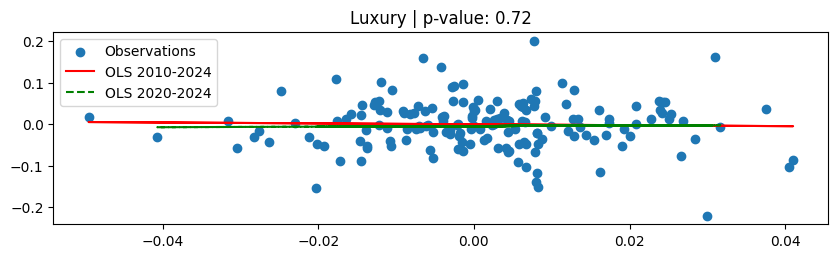

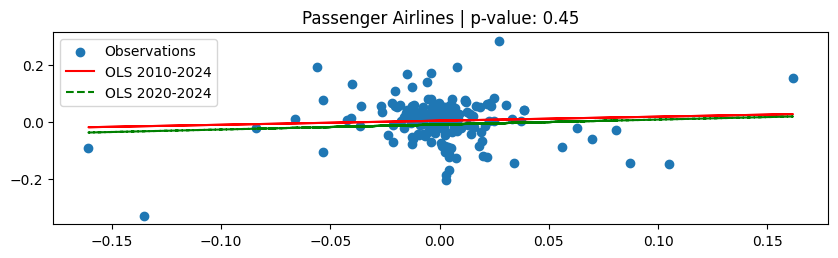

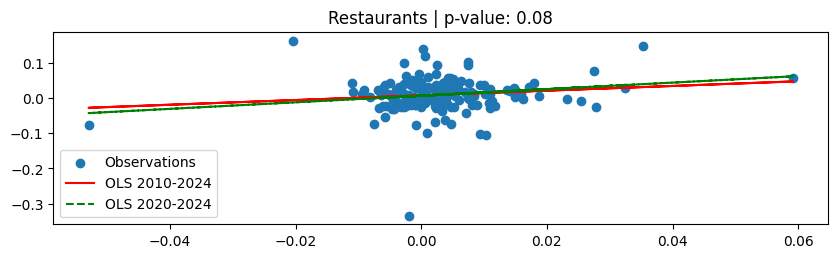

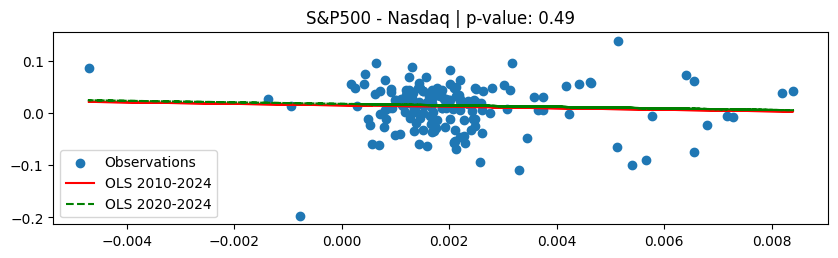

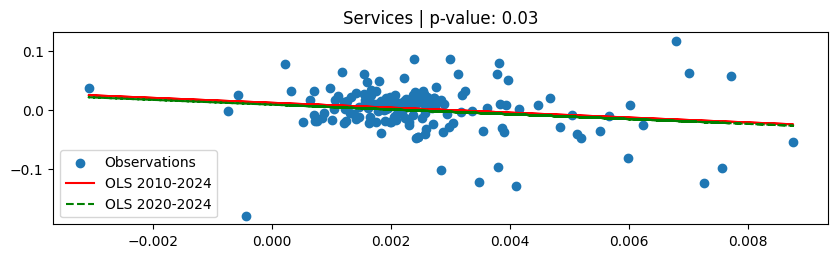

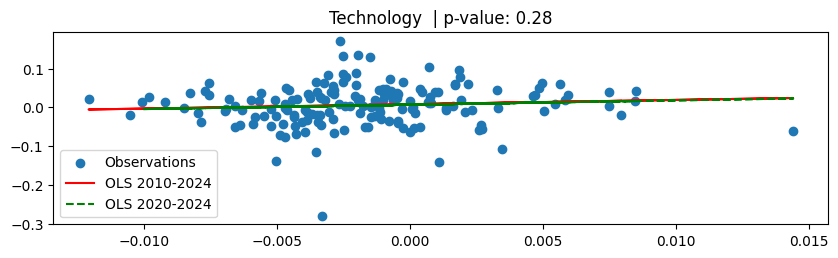

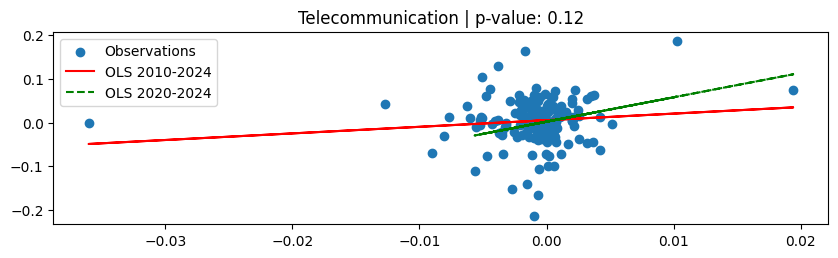

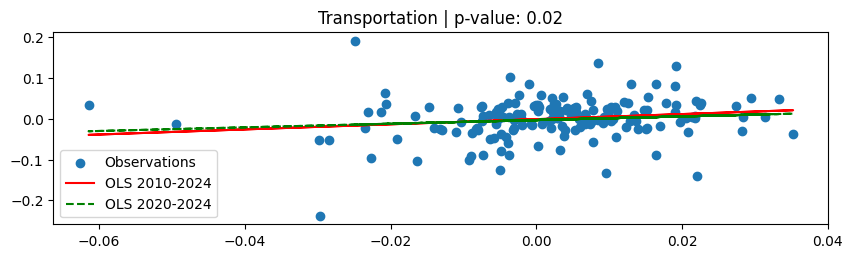

In [30]:
#p_dict = {}
#for p in np.round(np.arange(0.35,1.25,0.05),2):
recap_df = pd.DataFrame(index=cpi_dict.keys())
appendix_df = pd.DataFrame(index=sorted(cpi_dict.keys()))
recap_df_2019 = pd.DataFrame(index=cpi_dict.keys())

fig, axes = plt.subplots(int(len(cpi_dict)/2), 2, figsize=(16,12))

for i, key in enumerate(sorted(cpi_dict.keys())):
    
    stock, deleted = delete_outlier(stock_dict[key].pct_change(fill_method=None).loc[str(cpi_industry.index.min()):str(cpi_industry.index.max()),:],
                           threshold = .35, key = key, method = 'value', print_ = True)

    df = pd.concat((cpi_industry[cpi_dict[key]].pct_change(), stock.rename('Stock')),axis=1).dropna()[:'2024']
    #df['Stock'] = df['Stock'].shift(-1)
    #df = df.dropna()
    #df = df[df.index.year != 2020]
    x = df.iloc[:,0:1]
    y = df.iloc[:,1:2]
    model = sm.OLS(y, sm.add_constant(x)).fit()

    x2 = df.iloc[:,0:1]['2020':]
    y2 = df.iloc[:,1:2]['2020':]
    model_2019_ = sm.OLS(y2, sm.add_constant(x2)).fit()

    update_df(recap_df, model)
    industry_recap(appendix_df, deleted)
    update_df(recap_df_2019, model_2019_)

    # Unique plots
    plt.figure(figsize=(10,2.5))
    plt.scatter(x, y, label='Observations')
    plt.plot(x, model.predict(sm.add_constant(x)), color='r', label='OLS 2010-2024')
    plt.plot(x2, model_2019_.predict(sm.add_constant(x2)), color='g', ls='--', label='OLS 2020-2024')
    plt.title(f'{key} | p-value: {model.pvalues.iloc[1]:.2f}')
    plt.legend()   

    # All-in
    obs = axes[i//2,i%2].scatter(x, y)
    ols1 = axes[i//2,i%2].plot(x, model.predict(sm.add_constant(x)), color='r')
    ols2 = axes[i//2,i%2].plot(x2, model_2019_.predict(sm.add_constant(x2)), color='g', ls='--')
    axes[i//2,i%2].set_title(f'{key} | p-value: {model.pvalues.iloc[1]:.2f} | Correlation: {df.corr().iloc[0,1]:.2f}')
#fig.legend([obs, ols1, ols2], labels=['Observations','OLS 2010-2014','OLS 2020-2024'], loc='upper left', fontsize=13)
fig.suptitle('Regression of stock returns on the corresponding industry\'s CPI', fontsize=18)
fig.tight_layout()

#p_dict[p] = (recap_df.p_value_beta<0.05).sum()

In [594]:
print((recap_df.p_value_beta<0.05).sum(),'/',recap_df.p_value_beta.size)

7 / 20


In [32]:
recap = pd.concat([recap_df,recap_df_2019],axis=1, keys=['2010-2024','2020-2024']).sort_index()
recap = recap.style.map(highlight_p, subset=pd.IndexSlice[:, pd.IndexSlice[:,'p_value_beta']]).format('{:.2f}')
recap

### Fama french

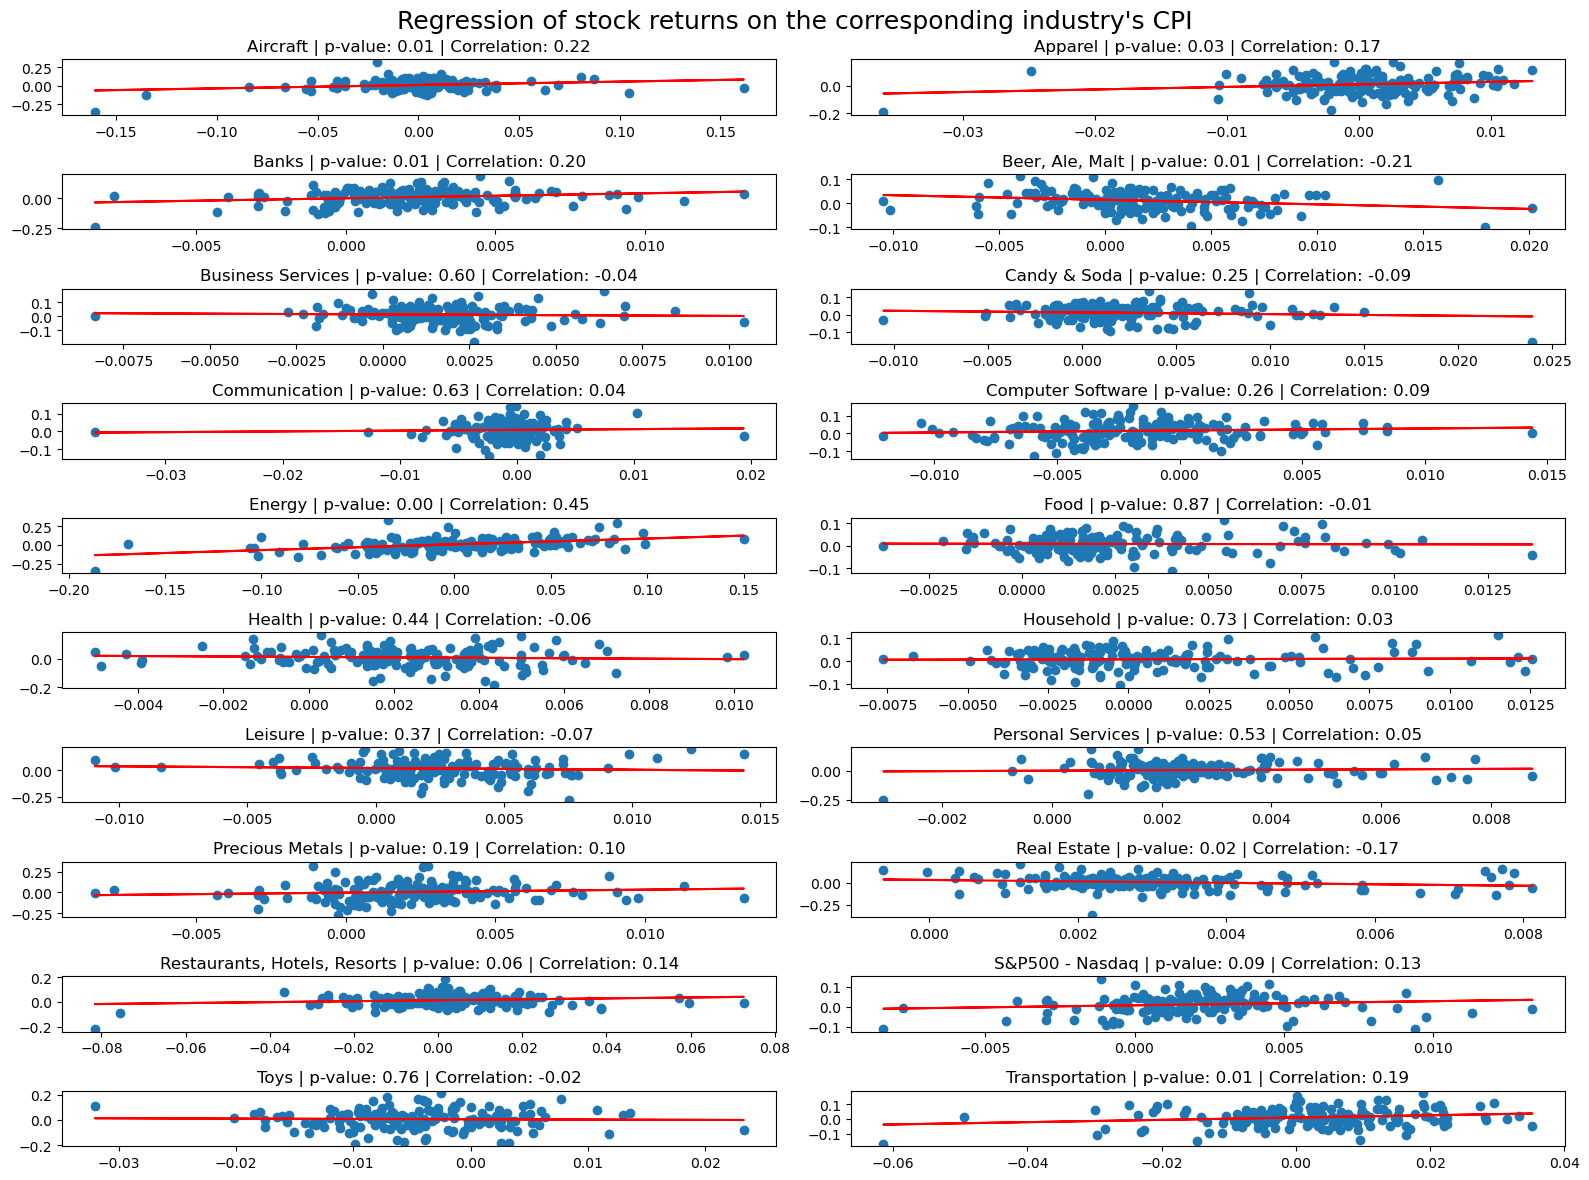

In [76]:
recap_df = pd.DataFrame(index=cpi_dict_ff.keys())

fig, axes = plt.subplots(int(len(cpi_dict_ff)/2), 2, figsize=(16,12))
for i, key in enumerate(sorted(cpi_dict_ff.keys())):
    stock = stock_dict[key].loc[str(cpi_industry.index.min()):str(cpi_industry.index.max())]

    df = pd.concat((cpi_industry[cpi_dict_ff[key]].pct_change(), stock.rename('Stock')),axis=1).dropna()[:'2024']
    df['Stock'] = df['Stock'].shift(1)
    df.dropna(inplace=True)
    #df = df[df.index.year != 2020]
    x = df.iloc[:,0:1]
    y = df.iloc[:,1:2]
    model = sm.OLS(y, sm.add_constant(x)).fit()
    update_df(recap_df, model)
    # All-in
    obs = axes[i//2,i%2].scatter(x, y)
    ols1 = axes[i//2,i%2].plot(x, model.predict(sm.add_constant(x)), color='r')
    axes[i//2,i%2].set_title(f'{key} | p-value: {model.pvalues.iloc[1]:.2f} | Correlation: {df.corr().iloc[0,1]:.2f}')
fig.suptitle('Regression of stock returns on the corresponding industry\'s CPI', fontsize=18)
fig.tight_layout()

In [77]:
print((recap_df.p_value_beta<0.05).sum(),'/',recap_df.p_value_beta.size)

7 / 20


In [60]:
recap_df = recap_df.sort_index()
recap = recap_df.style.map(highlight_p, subset=pd.IndexSlice[:,'p_value_beta']).format('{:.2f}')
recap

AttributeError: 'Styler' object has no attribute 'map'

## Significance level

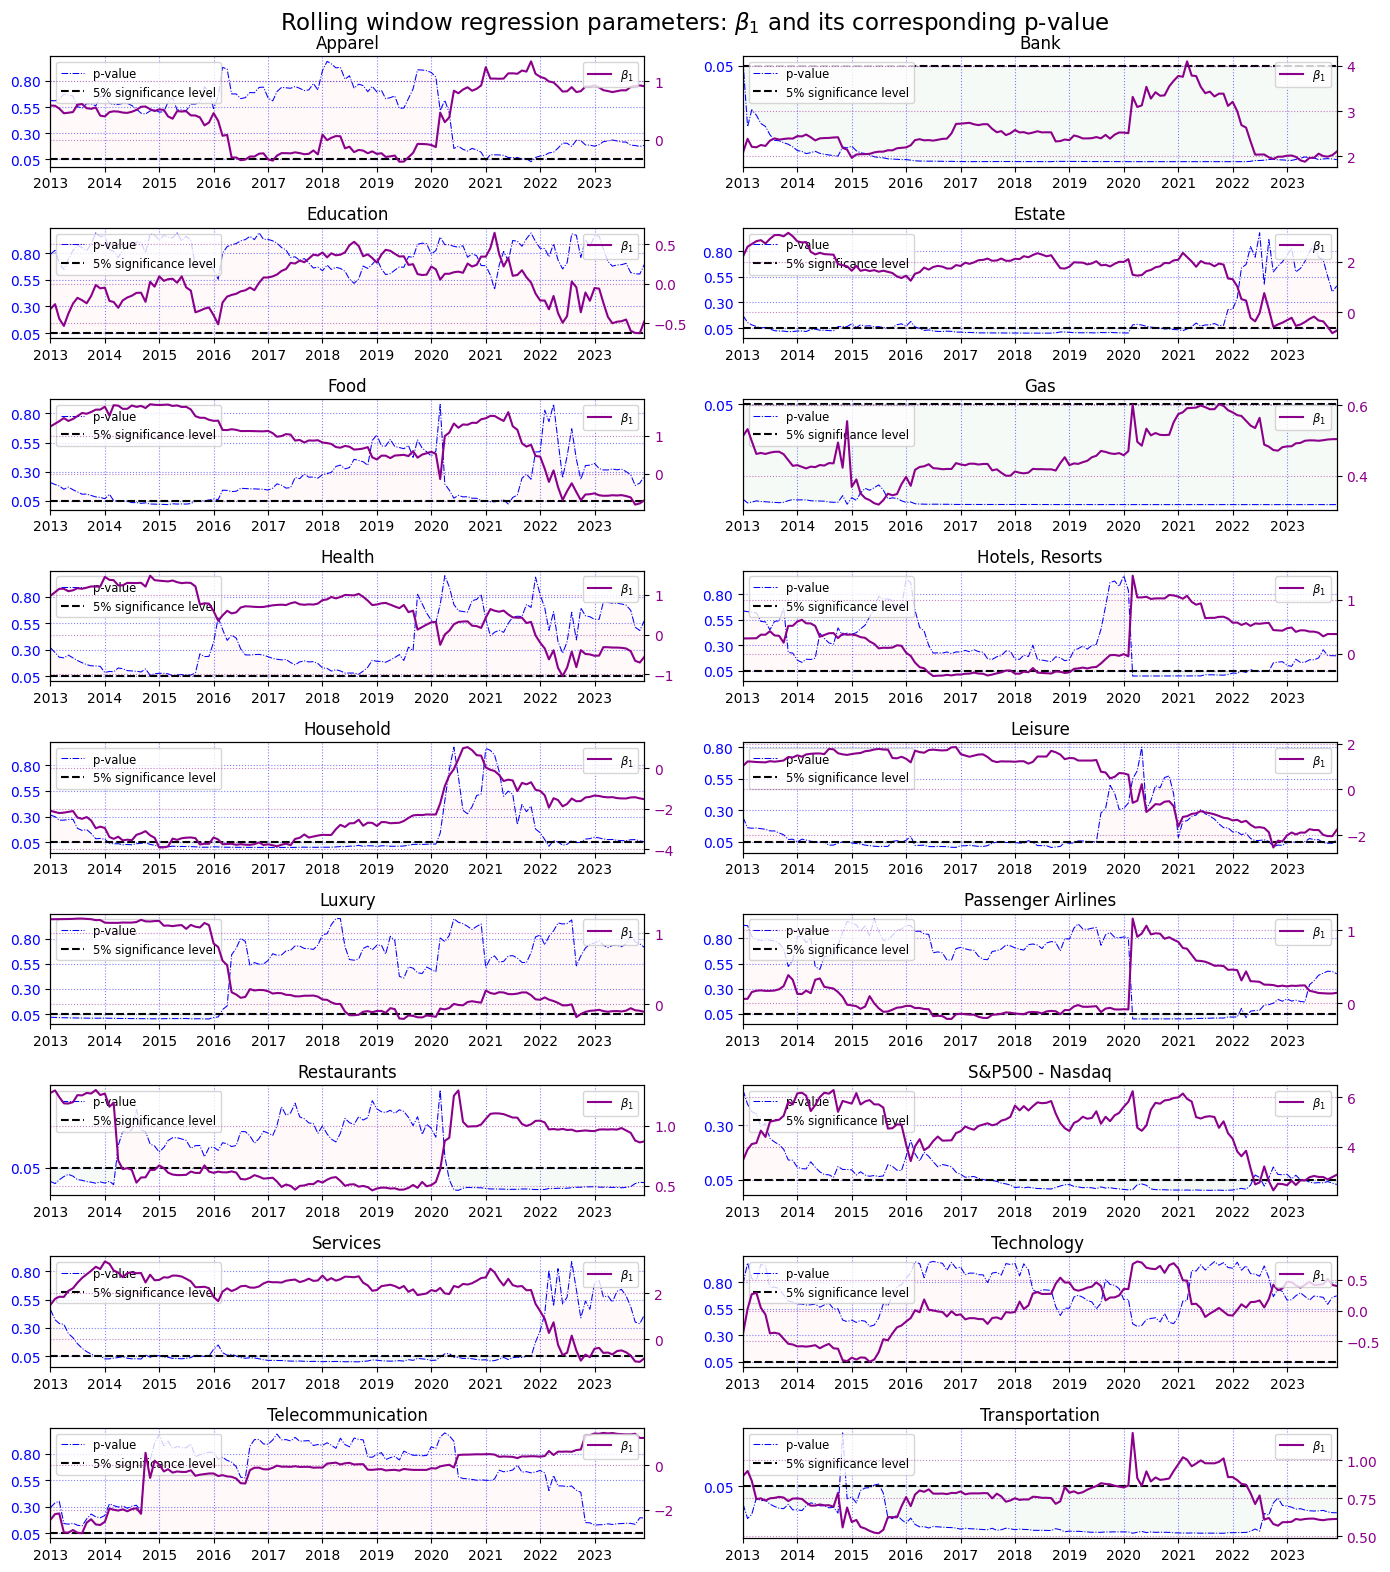

In [438]:
fig, axes = plt.subplots(int(len(cpi_dict)/2), 2, figsize=(14,16))

for i, key in enumerate(sorted(cpi_dict.keys())):

    stock = delete_outlier(stock_dict[key].pct_change(fill_method=None).loc[str(cpi_industry.index.min()):str(cpi_industry.index.max()),:],
                           threshold = .35, key = key, method = 'value', print_ = False)[0]

    df = pd.concat((cpi_industry[cpi_dict[key]].pct_change(), stock.rename('Stock')),axis=1).dropna()
    #df['Stock'] = df['Stock'].shift(-1)
    #df = df.dropna()
    x = df.iloc[:,0:1]
    y = df.iloc[:,1:2]
    
    exog = sm.add_constant(x, prepend=True)
    mod = RollingOLS(y, x, window=x.shape[0], min_nobs=12*3, expanding=True)
    rolling_res = mod.fit(use_t=True)
    rolling_p = pd.DataFrame(np.hstack((rolling_res.pvalues, rolling_res.params.values)), columns=['p_value','params'], index=x.index).dropna()
 
    idx = rolling_p.index.astype('datetime64[ns]')
    
    ax = axes[i//2,i%2]
    ax.set_yticks( (list(ax.get_yticks()).remove(0.05) + [0.05]) if 0.05 in ax.get_yticks() else ax.get_yticks() + [0.05])
    ax.tick_params(axis='y', labelcolor='blue')
    ax2 = axes[i//2,i%2].twinx()
    ax2.tick_params(axis='y', labelcolor='darkmagenta')
    
    p = ax.plot(idx, rolling_p['p_value'], color='blue', ls='-.', lw=0.75, label='p-value')
    five_p_line = ax.axhline(0.05, c='black', ls='--', label='5% significance level')
    ax.fill_between(idx, rolling_p['p_value'], 0.05,  where=rolling_p['p_value']>0.05, color='red', alpha=0.025, interpolate=True)
    ax.fill_between(idx, rolling_p['p_value'], 0.05,  where=rolling_p['p_value']<0.05, color='green', alpha=0.035, interpolate=True)
    beta = ax2.plot(idx, rolling_p['params'], color='darkmagenta', label=r'$\beta_1$')
    
    ax.set_title(f'{key}')# | Average p-value: {rolling_p.iloc[:,0:1].mean().iloc[0]:.2f}')
    
    ax.legend(loc=2, fontsize='small', markerscale=0.7)
    ax2.legend(loc=1, fontsize='small', markerscale=0.7)
    ax.grid(ls=':', alpha=.5, color='blue')
    ax2.grid(ls=':', alpha=.5, color='darkmagenta')
    ax.autoscale(tight=True, axis='x')
    ax2.autoscale(tight=True, axis='x')

fig.suptitle(r'Rolling window regression parameters: $\beta_1$ and its corresponding p-value', fontsize=16.5)
fig.tight_layout()

## Pooled Regressions

In [427]:
print(len(np.array(li).reshape(-1,)))
print((np.array(li).reshape(-1,) < 0.05).sum())
print(np.mean(np.array(li).reshape(-1,)))

100
22
0.3538868198451788


In [613]:
def pooled_ols_recap(key, model, i):
    multi_df[key] = list(model.params.round(3)) + [f'{model.rsquared_adj:.2%}']
    p_values = [0] * len(model.pvalues.values)    
    for idx, p in enumerate(model.pvalues.values):
        if p < 0.02:
            p_values[idx] = f'{model.pvalues.values[idx]:.2f}***'
        elif p < 0.06:
            p_values[idx] = f'{model.pvalues.values[idx]:.2f}**'
        elif p < 0.11:
            p_values[idx] = f'{model.pvalues.values[idx]:.2f}*'
        else:
            p_values[idx] = f'{model.pvalues.values[idx]:.2f}'
    multi_df[' '*i] = p_values + [(model.pvalues.values < 0.05).sum()] #['']

In [615]:
multi_df.T.iloc[1::2]

,const,CPI,Real_GDP,Avg_h_earnings,Money Supply,FXCM,Adj. R2
,0.48,0.31,0.21,0.05**,0.73,0.72,0
,0.12,0.40,0.79,0.00***,0.03**,0.79,2
,0.39,0.21,0.44,0.00***,0.06**,0.33,1
,0.01***,0.29,0.50,0.09*,0.54,0.76,1
,0.09*,0.74,0.92,0.00***,0.08*,0.24,1
,0.00***,0.97,0.09*,0.01***,0.40,0.67,2
,0.08*,0.73,0.21,0.00***,0.04**,0.97,2
,0.60,0.78,0.90,0.01***,0.03**,0.35,2
,0.09*,0.00***,0.77,0.16,0.86,0.02***,2
,0.08*,0.28,0.39,0.48,0.69,0.84,0


In [711]:
#FF
multi_df = pd.DataFrame()
li = []
for i, key in enumerate(sorted(cpi_dict_ff.keys())):

    stock = stock_dict[key].loc[str(cpi_industry.index.min()):str(cpi_industry.index.max())]

    df = pd.concat([stock.rename('Stock').shift(1), cpi_industry[cpi_dict_ff[key]].pct_change().rename('CPI'), 
                    GDP.pct_change(), avg_h_e.pct_change(), M2.pct_change(), 
                     USD.pct_change()],
                   axis=1).dropna()[:'2024']

    y = df.iloc[:,0:1]
    x = df.iloc[:,1:]
    model = sm.OLS(y, sm.add_constant(x)).fit()
    pooled_ols_recap(key, model, i)
    li.append(model.pvalues.iloc[1:].values)
multi_df.index = (list(model.params.index.values) + ['Adj. R2'])
multi_df.T

,const,CPI,Money Supply,FXCM,Adj. R2
Aircraft,0.023,0.281,-1.864,0.201,7.19%
,0.00***,0.12,0.01***,0.53,2
Apparel,0.01,1.975,0.155,0.247,1.70%
,0.15,0.04**,0.84,0.43,1
Banks,0.006,3.96,-0.765,0.542,5.73%
,0.45,0.02***,0.24,0.07*,1
"Beer, Ale, Malt",0.016,-1.845,-0.411,-0.024,3.34%
,0.00***,0.01***,0.30,0.90,2
Business Services,0.015,-1.756,-0.243,0.406,0.21%
,0.01***,0.41,0.67,0.13,1


In [632]:
dt.columns

Index(['Agric', 'Food ', 'Soda ', 'Beer ', 'Smoke', 'Toys ', 'Fun  ', 'Books',
       'Hshld', 'Clths', 'Hlth ', 'MedEq', 'Drugs', 'Chems', 'Rubbr', 'Txtls',
       'BldMt', 'Cnstr', 'Steel', 'FabPr', 'Mach ', 'ElcEq', 'Autos', 'Aero ',
       'Ships', 'Guns ', 'Gold ', 'Mines', 'Coal ', 'Oil  ', 'Util ', 'Telcm',
       'PerSv', 'BusSv', 'Hardw', 'Softw', 'Chips', 'LabEq', 'Paper', 'Boxes',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Banks', 'Insur', 'RlEst', 'Fin  ',
       'Other'],
      dtype='object')

In [ ]:
print((np.array(li).reshape(-1,) < 0.05).sum(),'/',len(np.array(li).reshape(-1,)))
print(np.mean(np.array(li).reshape(-1,)))

In [720]:
for col in df.columns:
    print(f'{col}: {adfuller(df[col])[1]:.4f}')

Stock: 0.0000
CPI: 0.0000
Money Supply: 0.0001
FXCM: 0.0014


In [636]:
order_selection = VAR_model.select_order(maxlags=6)
order_selection.summary()

,AIC,BIC,FPE,HQIC
0,-53.44,-53.20*,6.163e-24,-53.35
1,-53.86,-52.19,4.116e-24,-53.24
2,-53.28,-50.18,7.947e-24,-52.12
3,-52.61,-48.08,1.940e-23,-50.91
4,-52.65,-46.69,2.981e-23,-50.42
5,-54.02,-46.62,1.958e-23,-51.25
6,-58.82*,-49.99,1.132e-24*,-55.51*


In [725]:
VAR_model = VAR(df.iloc[:,]).fit(6, trend='c',).summary()
VAR_model

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Jun, 2024
Time:                     00:48:09
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -31.0854
Nobs:                     152.000    HQIC:                  -32.2667
Log likelihood:           1750.97    FPE:                4.37548e-15
AIC:                     -33.0748    Det(Omega_mle):     2.37962e-15
--------------------------------------------------------------------
Results for equation Stock
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.010035         0.008157            1.230           0.219
L1.Stock               -0.126889         0.088606           -1.432           0.152
L1.CPI                  0.156577         0.406821   

In [647]:
VAR_model.predict

<bound method VAR.predict of <statsmodels.tsa.vector_ar.var_model.VAR object at 0x7fbfba7d5a60>>

In [684]:
VECM(df, seasons=5, k_ar_diff=3).fit().summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-0.1028,0.040,-2.585,0.010,-0.181,-0.025
season2,-0.0162,0.025,-0.659,0.510,-0.064,0.032
season3,-0.0412,0.043,-0.949,0.343,-0.126,0.044
season4,-0.1054,0.035,-3.000,0.003,-0.174,-0.037
L1.Stock,-0.0748,0.164,-0.455,0.649,-0.397,0.247
L1.CPI,-0.9660,0.629,-1.535,0.125,-2.199,0.267
L1.Real_GDP,2.8829,0.901,3.200,0.001,1.117,4.649
L1.Avg_h_earnings,10.8113,4.707,2.297,0.022,1.586,20.036
L1.Money Supply,-0.9585,2.022,-0.474,0.635,-4.921,3.004
L1.FXCM,-0.8108,0.505,-1.604,0.109,-1.801,0.180


In [456]:
from statsmodels.tsa.vector_ar.vecm import VECM, select_order

In [683]:
order_result = select_order(df, maxlags=3, deterministic="ci")
order_result.summary()

,AIC,BIC,FPE,HQIC
0,-53.86,-52.19*,4.116e-24,-53.24
1,-53.28,-50.18,7.947e-24,-52.12
2,-52.61,-48.08,1.940e-23,-50.91
3,-52.65,-46.69,2.981e-23,-50.42
4,-54.02,-46.62,1.958e-23,-51.25
5,-58.82*,-49.99,1.132e-24*,-55.51*


In [ ]:
model = VECM(data, deterministic="ci", seasons=2,
             k_ar_diff=3,  # =3
             coint_rank=0)  # =1
model_fit = model.fit()
model_fit.summary()